In [32]:
import numpy as np
from scipy.stats import spearmanr
from scipy import sparse
import cmath
from sklearn.decomposition import PCA
import sys, os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm



sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')
from futils import read_metrics_filepath, extract_weights, data2percentile, get_hilbert, get_phases, get_synch, jthreshold

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
### FUNCTIONS NEEDED FOR NOTEBOOK

# basics

def plot_fc(gt_filepath, idx):
    f = np.load(gt_filepath + '/fc-%d.npz' % idx)
    fc = f['fc']
    f.close()
       
    plt.figure()
    plt.imshow(fc, cmap='inferno', vmin=-1., vmax=1.)
    plt.xticks([]); plt.yticks([])
    
def plot_bin(bin_filepath, idx):
    binary = sparse.load_npz(bin_filepath + '/bin-fc-%d.npz' % idx)
    binary = binary.toarray()
        
    plt.figure()
    plt.imshow(binary, cmap='gray_r', vmin=0., vmax=1.)
    plt.xticks([]); plt.yticks([])
    
    
def extract_fc_matrix(gt_filepath, idx):
    f = np.load(gt_filepath + '/fc-%d.npz' % idx)
    fc = f['fc']
    f.close()
    return fc.astype('float32')

### ASSEMBLIES

def extract_ensembles(idxs, component, temporal_cutoff, spatial_cutoff=0.90):
    from futils import ensemble_detection
    
    raster = []
    for i in idxs:
        d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
        locs = None
        if component == 'shubs':
            locs = np.where( (d > spatial_cutoff) & (e > spatial_cutoff))[0]
        elif component == 'nhubs':
            locs = np.where(d > spatial_cutoff)[0]
        elif component == 'hubs':
            locs = np.where( (d > spatial_cutoff) & (e <= spatial_cutoff) )[0]
        raster_slice = np.zeros(len(d), dtype='uint8')
        raster_slice[locs] = 1
        raster.append(raster_slice)
        
    raster = np.asarray(raster, dtype='uint8')
    raster_mean = np.mean(raster, axis=0)
    mean_cutoff = np.percentile(raster_mean, temporal_cutoff*100.)
    valid_idxs = np.where(raster_mean > mean_cutoff)[0]
    raster = raster[:, valid_idxs]
    
    ensemble_kwargs = {'metric': 'cosine', 'k': 20, 'stopping_condition': 1e-3, 'resolution': 1.0}
    sam, umap_data, cluster_labels = ensemble_detection(raster.T, run_sam=True, **ensemble_kwargs)
    print(len(cluster_labels))
    return sam, umap_data, cluster_labels, raster, valid_idxs

def sort_dstructure(raster, labels, dtype='uint8'):
    labels = np.asarray(labels, dtype='uint32')
    sorted_raster = np.zeros_like(raster, dtype=dtype)
    label_set = np.sort(list(set(labels)))
    csz_lst = []
    for i in label_set:
        idxs = np.where(labels == i)[0]
        csize = len(idxs)
        csz_lst.append(csize)
    
    count = 0        
    for i in np.argsort(csz_lst)[::-1]:
        label = label_set[i]
        idxs = np.where(labels == label)[0]
        csz = len(idxs)
        sorted_raster[:,count:count+csz] = raster[:, idxs]
        count += csz
    return sorted_raster, np.sort(csz_lst)[::-1]

#sorted_coords = sort_coords(coords, X['labels'])

# plot modularities
def plot_umap_clusters(umap, labels):
    labels = np.asarray(labels, dtype='uint32')
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].scatter(*umap.T, color='k')
    for i in range(np.min(labels), np.max(labels) + 1):
        idxs = np.where(labels == i)[0]
        ax[1].scatter(*umap[idxs,:].T)
    plt.show()
    
def plot_modularities(X, xvals, labels):
    xvals = xvals[:-1]
    colors = ['k', 'r', 'b']
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    for (xp, x) in enumerate(X):
        smod, tmod = [], []
        sorted_keys = np.sort(list(x.keys()))
        for key in sorted_keys[:-1]:
            smod.append(x[key]['smod'])
            tmod.append(x[key]['tmod'])
            
        ax[0].plot(xvals, smod, color=colors[xp], label=labels[xp])
        ax[1].plot(xvals, tmod, color=colors[xp], label=labels[xp])

        #ax[0].legend()
        #ax[1].legend()
        
    plt.show()
    
def plot_raster_info(mean_trace, idxs, data_dict, title):
    
    sorted_raster = data_dict['sorted raster']
    csz_lst       = data_dict['csz_lst']
    T = sorted_raster.shape[0]
    
    spatial_corr = np.corrcoef(sorted_raster.T)
    spatial_modularity   = data_dict['smod']  
    
    temporal_corr = np.corrcoef(sorted_raster)
    temporal_modularity   = data_dict['tmod']  
    
    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].set_title(title)
    ax[0].imshow(sorted_raster.T, cmap='gray', vmin=0., vmax=1., aspect='auto')
    count = 0
    for sz in csz_lst:
        ax[0].plot(range(T), np.ones(T) * count, color='c')
        count += sz
    #ax2 = ax[0].twinx()
    #ax2.plot(np.range(-120, idxs[-1]))
    ax[1].imshow(np.clip(spatial_corr,0.,1.), cmap='gray_r', vmin=0., vmax=1.)
    ax[1].set_title('spatial modularity: %0.3f' % spatial_modularity)
    ax[2].imshow(np.clip(temporal_corr,0.,1.), cmap='gray_r', vmin=0., vmax=1.)
    #ax[2].set_title('tmod: %0.3f. ediff: %0.3f' % (temporal_modularity, eyediff) )
    plt.show()

#     fig, ax = plt.subplots(figsize=(12,8))
#     ax.set_title(title)
#     ax.imshow(sorted_raster.T, cmap='gray', vmin=0., vmax=1., aspect='auto')
#     count = 0
#     for sz in csz_lst:
#         ax.plot(range(T), np.ones(T) * count, color='c')
#         count += sz

    


# SPATIAL

def raster_frac_active(raster):
    factive = []
    T, N = raster.shape
    for t in range(T):
        rslice = raster[t,:]
        nactive = np.sum(rslice)
        factive.append(nactive / float(N))
    return np.asarray(factive, dtype='float32')

def raster_assembly_sparsity(unsorted_raster, labels, cutoff=0.50):
    T, N = unsorted_raster.shape
    ordered_label_set = np.sort(list(set(labels)))
    assembly_szs = []
    sorted_raster = np.zeros_like(unsorted_raster, dtype='uint8')
    count = 0
    for label in ordered_label_set:
        idxs = np.where(labels == label)[0]
        assembly_szs.append(len(idxs))
        sorted_raster[:,count:count+len(idxs)] = unsorted_raster[:, idxs]
        count += len(idxs)    
    sparsity_lst = []
    for t in range(T):
        count = 0
        active_assemblies = 0
        for sz in assembly_szs:
            current_assembly = sorted_raster[t,count:count+sz]
            count += sz
            if np.sum(current_assembly)/float(sz) > cutoff: active_assemblies += 1
        sparsity_lst.append(active_assemblies / float(len(assembly_szs)))
    return np.asarray(sparsity_lst, dtype='float32')



def get_overlapped(A, validA, B, validB):
    from copy import deepcopy
    Acopy, Bcopy = deepcopy(A), deepcopy(B)
    overlap_idxs = set(validA) & set(validB)
    overlap_a_locs = [list(validA).index(i) for i in overlap_idxs]
    overlap_b_locs = [list(validB).index(i) for i in overlap_idxs]
    Ax = Acopy[:,overlap_a_locs]
    Bx = Bcopy[:,overlap_b_locs]
    return Ax, Bx, overlap_idxs


# TEMPORAL

def time_active(raster):
    return np.sum(raster, axis=0)

def continuously_active(raster):
    T, N = raster.shape
    time_active_continuously = {n: [] for n in range(N) }
    for n in range(N):
        raster_slice = raster[:,n]
        active = False
        active_count = 0
        for t in range(T):
            if raster_slice[t]:
                if not active:
                    active = True
                active_count += 1
            if not raster_slice[t]:
                if active:
                    active = False
                    time_active_continuously[n].append(active_count)
                    active_count = 0        
            if t == T - 1 and raster_slice[t]:
                time_active_continuously[n].append(active_count)
                
    ntimes_active = []
    for n in range(N):
        ntimes_active.append(len(time_active_continuously[n])/float(T))
    plt.figure()
    plt.hist(ntimes_active, color='k', rwidth=0.65, density=True)
    plt.show()
       
    mean_time_active_continuously = np.zeros((N,), dtype='float32')
    for n in range(N):
        times = time_active_continuously[n]
        if len(times) == 0:
            mean_time_active_continuously[n] = 0.
        else:
            mean_time_active_continuously[n] = np.mean(times)
    return mean_time_active_continuously



def plot_time_superhub_active(tsa, T, valid_coords, full_coords):
    T = 60
    colors=cm.inferno(np.arange(0, T))
    norm = matplotlib.colors.Normalize(vmin=0.0, vmax=T)
    m = cm.ScalarMappable(norm=norm,cmap=cm.inferno)
    final_colors = []
    for t in tsa:
        ut = min(int(t), T-1)
        final_colors.append(m.to_rgba(ut))


    fig = plt.figure(figsize=(12,8))
    ax = plt.axes(projection='3d')
    ax.scatter(*full_coords[:,:].T, alpha=0.05, color='k')
    ax.scatter(*valid_coords[:,:].T, alpha=1.0, color=final_colors)     
    ax.view_init(90, 0)
    #ax.set_ylim([0, 160])
    #ax.set_xlim([80, 220])
    #fig.colorbar(m, ax=ax)
    plt.show()
    



In [230]:
fish_id = 5
traces_filepath = '../data/fish-%i-processed.npz' % fish_id
bin_filepath    = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i/bin' % fish_id
gt_filepath     = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i/gt' % fish_id
# snap_filepath   = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i/snap' % fish_id
metrics_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i/graph-metrics' % fish_id

nmatrices = 2380
window = 120
presz_start_idx = 500
sz_start_idx = 2190
#fish 2 - 1370
#fish 3 - 1270
#fish 5 - 2190
#fish 6 - 1360

f = np.load(traces_filepath)
traces = f['traces']
coords = f['coords']
f.close()
N, T = traces.shape
complete_times = np.arange(0, traces.shape[1]) * 0.5
dynamic_times  = complete_times[window:]
print(N,T)

6693 2500


(6701, 2500) (6701, 2500)


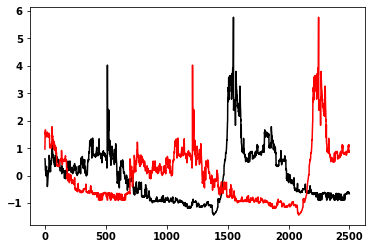

In [121]:
rolled_traces = []
for trace in traces:
    rnd_roll = np.random.randint(0, T)
    rolled_trace = np.roll(trace, rnd_roll)
    rolled_traces.append(rolled_trace)
rolled_traces = np.asarray(rolled_traces, dtype='float32')
print(traces.shape, rolled_traces.shape)

plt.figure()
plt.plot(traces[0,:], color='k')
plt.plot(rolled_traces[0,:], color='r')
plt.show()

np.savez('fish-%d-rolled.npz' % fish_id, traces=rolled_traces, coords=coords)

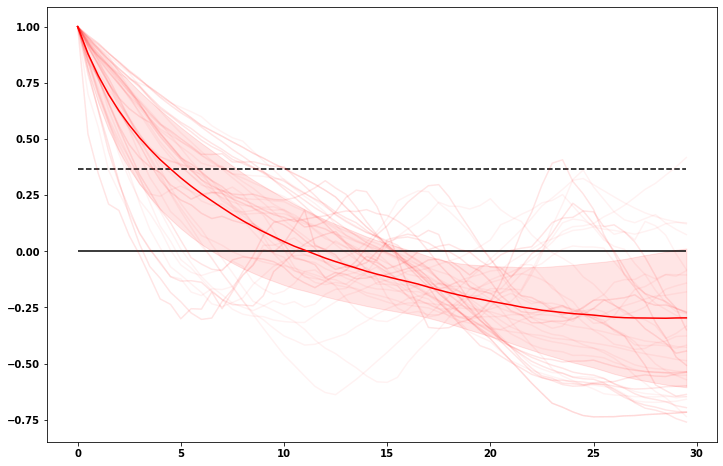

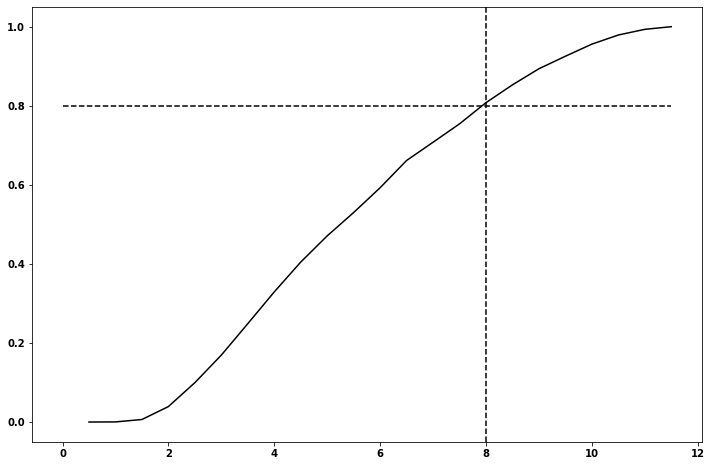

In [115]:
def autocorrelation (x) :
    xp = x-np.mean(x)
    f = np.fft.fft(xp)
    p = np.abs(f) ** 2
    #p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    t = int(x.size/2)
    return np.real(pi)[:t]/np.sum(xp**2)

### get autocorrs 
start, stop = 120, 240
timeconstant = 1./np.exp(1)
autocorrs = []
tconstants = []
for trace in traces:
    ac = autocorrelation(np.asarray(trace[start:stop]))
    tconstants.append(np.where(ac < timeconstant)[0][0]/2.)
    autocorrs.append(ac)
autocorrs = np.asarray(autocorrs, dtype='float32')
meanauto, stdauto = np.mean(autocorrs,axis=0), np.std(autocorrs,axis=0)

#### plot mean autocorr +/- std

autotimes = np.arange(len(meanauto))/2.
plt.figure(figsize=(12,8))
plt.plot(autotimes, meanauto, color='r')
plt.fill_between(autotimes, meanauto-stdauto, meanauto+stdauto, color='r', alpha=0.1)
plt.hlines(0, 0, max(autotimes), color='k')
plt.hlines(timeconstant, 0, max(autotimes), color='k', linestyle='--')

for i in range(50):
    r = np.random.randint(0, len(autotimes))
    plt.plot(autotimes, autocorrs[r], color='r', alpha=0.05)
plt.show()
                         
#### time constant distribution

bins = np.arange(0., np.max(tconstants)+0.5, 0.5)
hist, edges = np.histogram(tconstants, bins=bins)
cumul = np.cumsum(hist)
cumul = cumul / cumul[-1]
fig, ax = plt.subplots(figsize=(12,8))
#ax[0].hist(tconstants, color='k', rwidth=0.65, bins=bins, density=False)
ax.plot(edges[1:], cumul, color='k' )
ax.hlines(0.8, 0, np.max(edges), color='k', linestyle='--')
ax.axvline(np.where(cumul >= .80)[0][0]/2.+0.5, 0., 1., color='k', linestyle='--')
plt.show()



[autoreload of futils failed: Traceback (most recent call last):
  File "/mnt/d/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/mnt/d/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/mnt/d/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/mnt/d/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/mnt/d/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/mnt/d/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 300, in update_instances
    for obj in (obj for obj in objects if id(obj) not in visited):
  File 

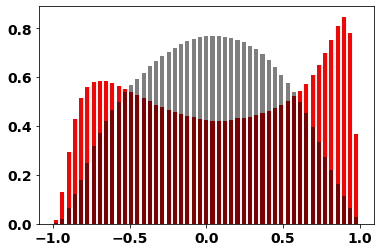

In [28]:
## Plot histogram of correlation values

baseline_idx = 25
presz_idx    = 900
sz_idx = sz_start_idx + 10

#read_fc_data(sz_idx)

bfc  = extract_weights(extract_fc_matrix(gt_filepath, baseline_idx), directed=False)
szfc = extract_weights(extract_fc_matrix(gt_filepath, sz_idx), directed=False)
bins = np.linspace(-1., 1., 50)

plt.figure()
plt.hist(szfc, bins=bins, density=True, color='r', rwidth=0.65)
plt.hist(bfc, bins=bins, density=True, color='k', rwidth=0.65, alpha=0.5)
plt.show()

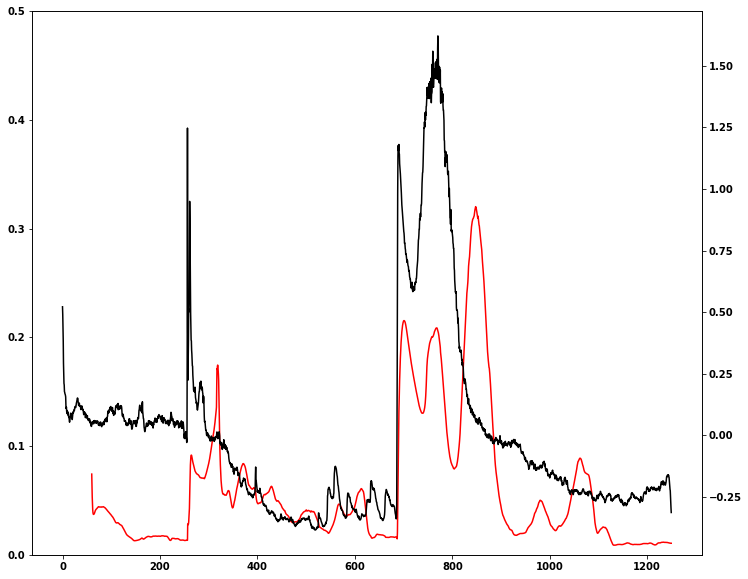

In [5]:
## Plot dynamic edge density

f = np.load('%s/densities.npz' % metrics_filepath)
densities = f['densities']
f.close()

fig, ax = plt.subplots(figsize=(12,10))
ax.plot(dynamic_times, densities, color='r')
# ax.set_xticks(np.arange(0, complete_times[-1], 120))
# ax.set_xticklabels(np.arange(0, complete_times[-1], 120), rotation=45)
ax.set_ylim([0, 0.5])
ax2 = ax.twinx()
ax2.plot(complete_times, np.mean(traces, axis=0), color='k')
# ax2.set_xticks(np.arange(0, complete_times[-1], 120))
# ax2.set_xticklabels(np.arange(0, complete_times[-1], 120), rotation=45)
plt.show()


(802, 8334) 802


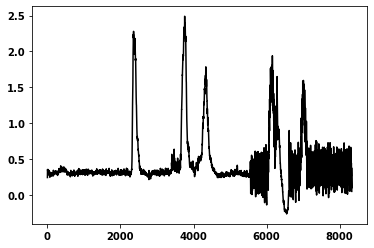

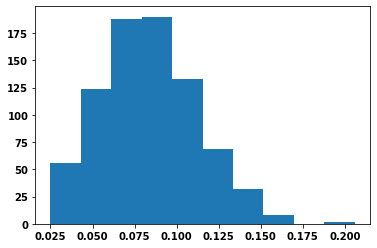

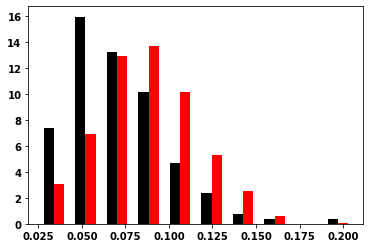

In [26]:
### if mouse start here


import numpy as np
import matplotlib.pyplot as plt

dg_id = 204
traces_filepath = '/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/data/dg_%d.npz' % dg_id
f = np.load(traces_filepath)
traces = f['traces']
valid_idxs = f['valid_idxs']
print(traces.shape, len(valid_idxs))
f.close()

metrics_filepath = '/mnt/f/dhh-soltesz-lab/DG-data/%d/fc/graph-metrics' %dg_id
f = np.load(metrics_filepath+'/'+'metrics-fc-101.npz')
deg = f['degree']
f.close()

plt.figure()
plt.plot(np.mean(traces,axis=0)[:], color='k')

plt.figure()
plt.hist(deg)
plt.show()

plt.figure()
plt.hist([deg[0:142], deg[142:]], color=['k', 'r'],density=True, rwidth=0.65)
plt.show()

In [306]:
## Extract graph metrics

#metrics_filepath = '/mnt/f/dhh-soltesz-lab/ca1-data/JF_200_105/graph-metrics'
# coords_filepath  = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f2/baseline/v1/additional-info-3152020.npz'
# f = np.load(coords_filepath)
# coords = f['spatial']

nmatrices=2380
dynamic_degree_centrality, dynamic_eigenvector_centrality, dynamic_clustering_coefficient = read_metrics_filepath(metrics_filepath, nmatrices, [], verbose=True)
dynamic_degree_centrality_percentile, dynamic_eigenvector_centrality_percentile, dynamic_cc_percentile  = [], [], []
method = 'max'

for i in range(len(dynamic_degree_centrality)):
    dynamic_degree_centrality_percentile.append(data2percentile(dynamic_degree_centrality[i], method=method))
    dynamic_eigenvector_centrality_percentile.append(data2percentile(dynamic_eigenvector_centrality[i], method=method))
    dynamic_cc_percentile.append(data2percentile(dynamic_clustering_coefficient[i], method=method))
dynamic_degree_centrality_percentile      = np.asarray(dynamic_degree_centrality_percentile, dtype='float32')
dynamic_eigenvector_centrality_percentile = np.asarray(dynamic_eigenvector_centrality_percentile, dtype='float32')
dynamic_cc_percentile = np.asarray(dynamic_cc_percentile, dtype='float32')

dynamic_ev_deg_correlation = []
for i in range(len(dynamic_degree_centrality_percentile)):
    deg = dynamic_degree_centrality_percentile[i]
    ev  = dynamic_eigenvector_centrality_percentile[i]
    
    rho, _ = spearmanr(deg, ev)
    dynamic_ev_deg_correlation.append(rho)
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


<Figure size 864x576 with 0 Axes>

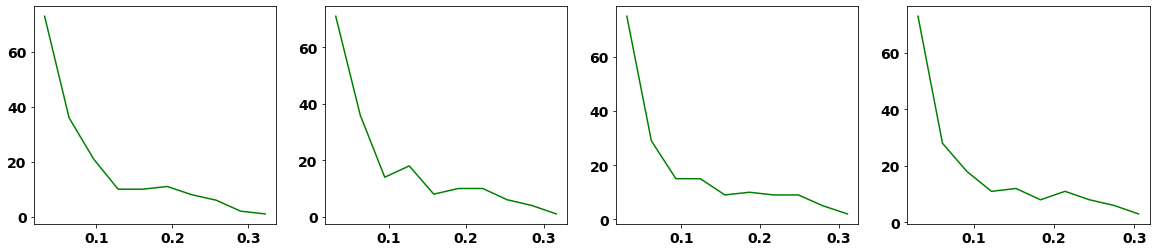

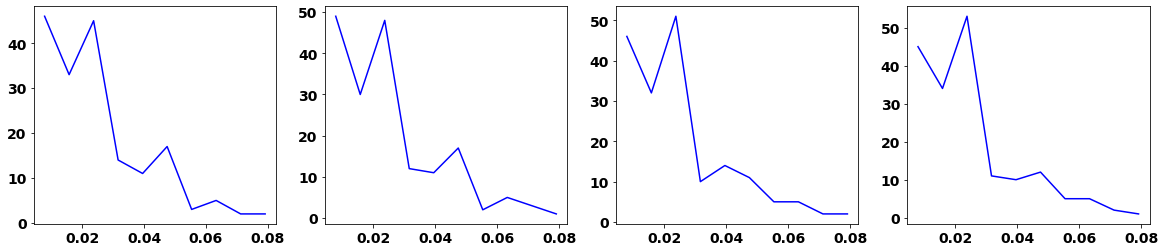

NameError: name 'start' is not defined

In [31]:
color=cm.cool(np.linspace(0,1,nmatrices))
bins = np.linspace(0.0, np.max(dynamic_degree_centrality), 50)
plt.figure(figsize=(12,8))


# baseline
fig, ax = plt.subplots(1,4,figsize=(20, 4))
for (idx,(i,c)) in enumerate(zip(range(10,14), color[10:14])):
    hist, edges = np.histogram(dynamic_degree_centrality[i,:], density=False)
    ax[idx].plot(edges[1:], hist, c='g', alpha=1.0)
plt.show()

fig, ax = plt.subplots(1,4,figsize=(20, 4))
for (idx,(i,c)) in enumerate(zip(range(1700,1704), color[1700:1704])):
    hist, edges = np.histogram(dynamic_degree_centrality[i,:], density=False)
    ax[idx].plot(edges[1:], hist, c='b', alpha=1.0)
plt.show()


#start = sz_start_idx + 10
stop = start + 4
fig, ax = plt.subplots(1,4,figsize=(20, 4))
for (idx,(i,c)) in enumerate(zip(range(start,stop), color[start:stop])):
    hist, edges = np.histogram(dynamic_degree_centrality[i,:], density=False)
    ax[idx].plot(edges[1:], hist, c='r', alpha=1.0)
plt.show()


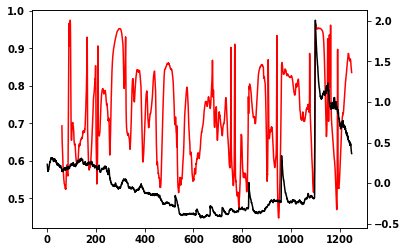

In [232]:
fig, ax = plt.subplots()
ax.plot(dynamic_times, dynamic_ev_deg_correlation, color='r')
#ax.plot(dynamic_ev_deg_correlation, color='r')
ax2 = ax.twinx()
ax2.plot(complete_times, np.mean(traces,axis=0), color='k')
plt.show()


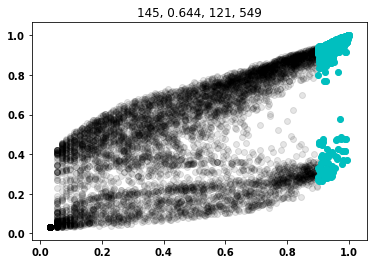

In [293]:
cutoff = 0.90
for i in range(145,146, 1):
    d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
    superhubs  = np.where( (d > cutoff) & (e > cutoff) )[0]
    all_hubs   = np.where( (d > cutoff) )[0]
    hubs       = np.where( (d > cutoff) & (e <= cutoff))[0]
    
    plt.figure()
    plt.scatter(d,e, color='k', alpha=0.1)
    #plt.scatter(d[hubs], e[hubs], color='b')
    #plt.scatter(d[superhubs], e[superhubs], color='r')
    plt.scatter(d[all_hubs], e[all_hubs], color='c')
    plt.title('%i, %0.3f, %i, %i' % (i, dynamic_ev_deg_correlation[i], len(hubs), len(superhubs)))
    plt.show()
    
    
#     fig = plt.figure(figsize=(12,8))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(*coords[:,:].T, color='k', alpha=0.05)
#     ax.scatter(*coords[superhubs,:].T, color='r', alpha=1.0)
#     ax.view_init(45,90)
    
    
# cutoff = 0.90
# for (idx,i) in enumerate(range(150, 160, 1)):
#     d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]

    
#     if idx == 0:
#         init_superhubs = np.where( (d > cutoff) & (e > cutoff) )[0]
#     superhubs = np.where( (d > cutoff) & (e > cutoff) )[0]
           
#     plt.figure()
#     plt.scatter(d,e, color='k', alpha=0.1)
#     #plt.scatter(d[hubs], e[hubs], color='b')
#     plt.scatter(d[superhubs], e[superhubs], color='r')
#     plt.scatter(d[init_superhubs], e[init_superhubs], color='c')
#     plt.title('%i, %0.3f, %i, %i' % (i, dynamic_ev_deg_correlation[i], len(hubs), len(superhubs)))
#     plt.show()

    


In [318]:
#temporal_cutoffs = np.arange(0.50, 0.95, 0.05, dtype='float32')
temporal_cutoffs = [0.50, 0.75, .95]
baseline_superhub_outputs, presz_superhub_outputs = {}, {}
baseline_naivehub_outputs, presz_naivehub_outputs = {}, {}
baseline_hub_outputs, presz_hub_outputs = {}, {}

for (i,tc) in enumerate(temporal_cutoffs):
    s, e = 0, 360
    baseline_superhub_sam, baseline_superhub_umap, baseline_superhub_clabels, baseline_superhub_raster, baseline_superhub_valid_idxs = extract_ensembles(range(s,e), 'shubs', tc, spatial_cutoff=0.90)
    #baseline_naivehub_sam, baseline_naivehub_umap, baseline_naivehub_clabels, baseline_naivehub_raster, baseline_naivehub_valid_idxs = extract_ensembles(range(s,e), 'nhubs', tc)
    #baseline_hub_sam, baseline_hub_umap, baseline_hub_clabels, baseline_hub_raster, baseline_hub_valid_idxs = extract_ensembles(range(s,e), 'hubs', tc)


    s, e = 620, 620+360#sz_start_idx-120
    presz_superhub_sam, presz_superhub_umap, presz_superhub_clabels, presz_superhub_raster, presz_superhub_valid_idxs = extract_ensembles(range(s,e), 'shubs', tc, spatial_cutoff=0.90)
    #presz_naivehub_sam, presz_naivehub_umap, presz_naivehub_clabels, presz_naivehub_raster, presz_naivehub_valid_idxs = extract_ensembles(range(s,e), 'nhubs', tc)
    #presz_hub_sam, presz_hub_umap, presz_hub_clabels, presz_hub_raster, presz_hub_valid_idxs = extract_ensembles(range(s,e), 'hubs', tc)


    baseline_superhub_outputs[i] = {'sam': baseline_superhub_sam, 'umap': baseline_superhub_umap, 'labels': baseline_superhub_clabels, 'raster': baseline_superhub_raster, 'sorted raster': None, 'valid idxs': baseline_superhub_valid_idxs}
    #baseline_naivehub_outputs[i] = {'sam': baseline_naivehub_sam, 'umap': baseline_naivehub_umap, 'labels': baseline_naivehub_clabels, 'raster': baseline_naivehub_raster, 'sorted raster': None, 'valid idxs': baseline_naivehub_valid_idxs}
    #baseline_hub_outputs[i] = {'sam': baseline_hub_sam, 'umap': baseline_hub_umap, 'labels': baseline_hub_clabels, 'raster': baseline_hub_raster, 'sorted raster': None, 'valid idxs': baseline_hub_valid_idxs}

    
    presz_superhub_outputs[i] = {'sam': presz_superhub_sam, 'umap': presz_superhub_umap, 'labels': presz_superhub_clabels, 'raster': presz_superhub_raster, 'sorted raster': None, 'valid idxs': presz_superhub_valid_idxs}
    #presz_naivehub_outputs[i] = {'sam': presz_naivehub_sam, 'umap': presz_naivehub_umap, 'labels': presz_naivehub_clabels, 'raster': presz_naivehub_raster, 'sorted raster': None, 'valid idxs': presz_naivehub_valid_idxs}
    #presz_hub_outputs[i] = {'sam': presz_hub_sam, 'umap': presz_hub_umap, 'labels': presz_hub_clabels, 'raster': presz_hub_raster, 'sorted raster': None, 'valid idxs': presz_hub_valid_idxs}
    
    print(i, tc, len(temporal_cutoffs))

Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


3343


Transforming to str index.
Transforming to str index.


3323
0 0.5 3


Transforming to str index.
Transforming to str index.


1648


Transforming to str index.
Transforming to str index.


1647
1 0.75 3


Transforming to str index.
Transforming to str index.


331
331
2 0.95 3


...start 0


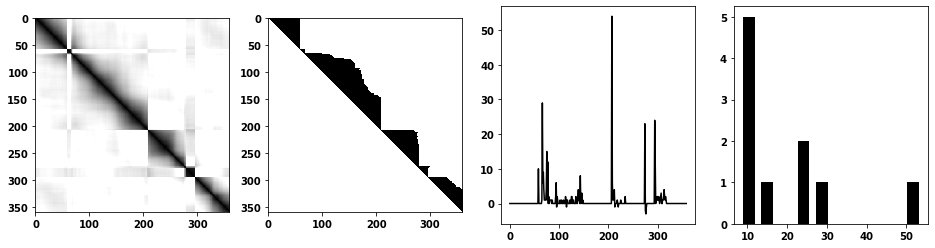

0.21429988866734292 0.641271852445402 6


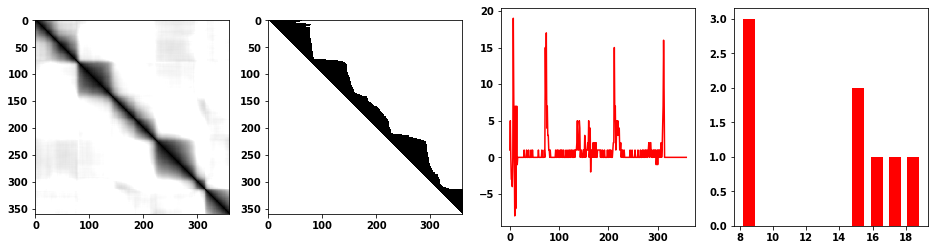

0.1827861157685489 0.6728680319285448 5
...start 1


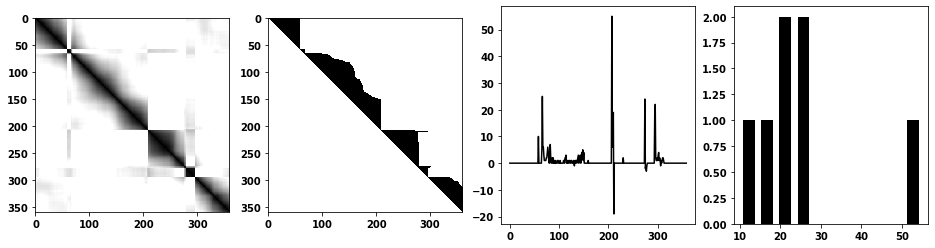

0.1943494951130283 0.6750192566680459 6


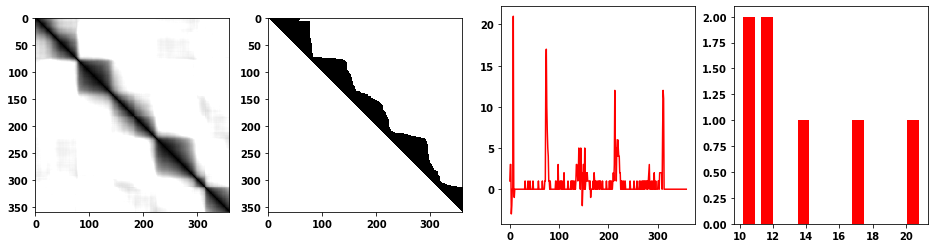

0.21538544352760344 0.6739109504527905 5
...start 2


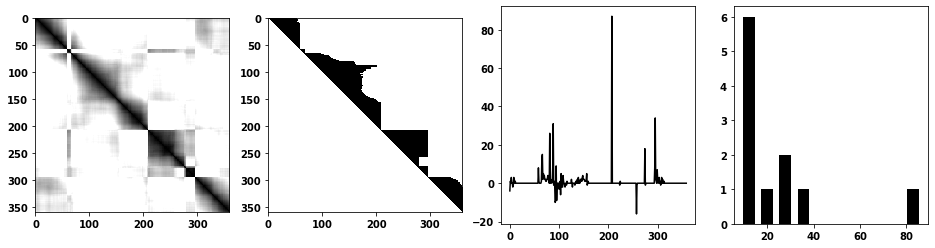

0.25136848927873984 0.6702883758533508 5


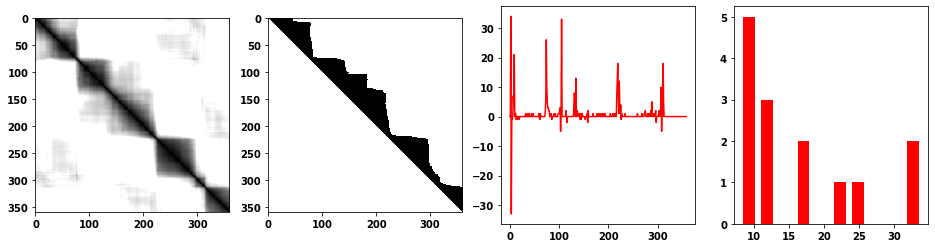

0.2405650754138002 0.6255437911896119 4


In [319]:
def extract_hierarchical_modularity(X, **kwargs):

    from futils import hierarchical_clustering
    from graph_utils import generate_igraph
    metric = kwargs.get('metric', 'euclidean')
    method = kwargs.get('method', 'ward')
    k = kwargs.get('k', 3)
    Xcorr = np.corrcoef(X)
    labels = hierarchical_clustering(X, k, metric='correlation', method='average')
    g, weights = generate_igraph(np.clip(Xcorr, 0., 1.), directed=False)
    modularity = g.modularity(labels, weights=weights)
    return labels, modularity

def extract_leiden_modularity(xcorr, res, binary=None, part=None):
    from graph_utils import leiden_clustering
    labels, modularity = leiden_clustering(xcorr , res=res, directed=False, part=part)   
    return labels, modularity


# sort and get modularities of 
def update(X, color):
    import matplotlib.patches as patches

    res = 1.0
    sorted_raster, csz_lst = sort_dstructure(X['raster'], X['labels'],dtype='uint8')
    sorted_coords, _       = sort_dstructure(coords[X['valid idxs'],:].T, X['labels'], dtype='float32')
    X['sorted raster'] = sorted_raster
    X['sorted coords'] = sorted_coords.T
    X['csz_lst'] = csz_lst
    
    raster_tcorr = np.corrcoef(sorted_raster) 
    raster_tcorr = np.clip(raster_tcorr, 0., 1.)
    
    raster_tcorr_bin = raster_tcorr.copy()
    raster_tcorr_bin[raster_tcorr<=0.10] = 0.
    raster_tcorr_bin[raster_tcorr>0.10] = 1.
    
    blocked_raster = np.zeros_like(raster_tcorr_bin, dtype='uint8')
    for i in range(raster_tcorr_bin.shape[0]):
        iszero = np.where(raster_tcorr_bin[i,i:] == 0)[0]
        if len(iszero) > 0:
            blocked_raster[i,0:i] = 0
            blocked_raster[i,i:i+iszero[0]] = 1
            blocked_raster[i,i+iszero[0]:] = 0
        else:
            blocked_raster[i,:i] = 0
            blocked_raster[i,i:] = 1
            
    state_spikes = []
    for i in range(blocked_raster.shape[0]):
        state_spikes.append(np.sum(blocked_raster[i,:]) + i)
    state_spikes = np.asarray(state_spikes)
    state_spikes_diff = np.diff(state_spikes)
    isi = state_spikes_diff[state_spikes_diff>=8]
    isi_mean = isi.mean()
    isi_std  = isi.std()
    
    fig, ax = plt.subplots(1,4, figsize=(16,4))
    ax[0].imshow(raster_tcorr, cmap='gray_r')
    ax[1].imshow(blocked_raster, cmap='gray_r')
    ax[2].plot(np.diff(state_spikes), color=color)
    ax[3].hist(isi, color=color, rwidth=0.65)
    plt.show()
    
    tlabels, tmod = extract_leiden_modularity(blocked_raster, res)
    
    
    raster_scorr = np.corrcoef(sorted_raster.T)
    raster_scorr = np.clip(raster_scorr, 0., 1.)
    membership = []
    mid = 0
    for sz in csz_lst:
        membership.extend([mid for _ in range(sz)])
        mid += 1   
    slabels, smod = extract_leiden_modularity(raster_scorr, res, binary=None, part=membership)
    
    time_seconds = float(raster_tcorr.shape[0])/2.        
    X['slabels'], X['smod'] = slabels, smod
    X['tlabels'], X['tmod'] = tlabels, tmod
    X['isi'] = isi
    X['tblock'] = blocked_raster
    X['ts'] = time_seconds
    print(smod, tmod, len(set(tlabels)))


sorted_keys = np.sort(list(baseline_superhub_outputs.keys()))
for key in sorted_keys:
    print('...start %d' % key)
    # superhubs
    update(baseline_superhub_outputs[key], 'k')
    update(presz_superhub_outputs[key], 'r')
  
    
#     # hubs
#     update(baseline_hub_outputs[key], 'k')
#     update(presz_hub_outputs[key], 'r')
    
#     # naive hubs
#     update(baseline_naivehub_outputs[key])
#     update(presz_naivehub_outputs[key])
    



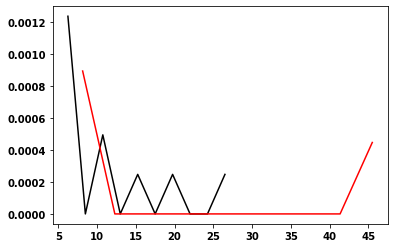

In [206]:
isi_baseline = baseline_superhub_outputs[0]['isi']
ts_baseline  = baseline_superhub_outputs[0]['ts']
isi_presz    = presz_superhub_outputs[0]['isi']
ts_presz =  presz_superhub_outputs[0]['ts']

bhist, bbins = np.histogram(isi_baseline/2., density=True)
bhist = bhist / ts_baseline
# bhist = np.cumsum(bhist)
# bhist = bhist / bhist[-1]

phist, pbins = np.histogram(isi_presz/2., density=True)
phist = phist / ts_presz
# phist = np.cumsum(phist)
# phist = phist / phist[-1]

plt.figure()
plt.plot(bbins[1:], bhist, color='k')
plt.plot(pbins[1:], phist, color='r')


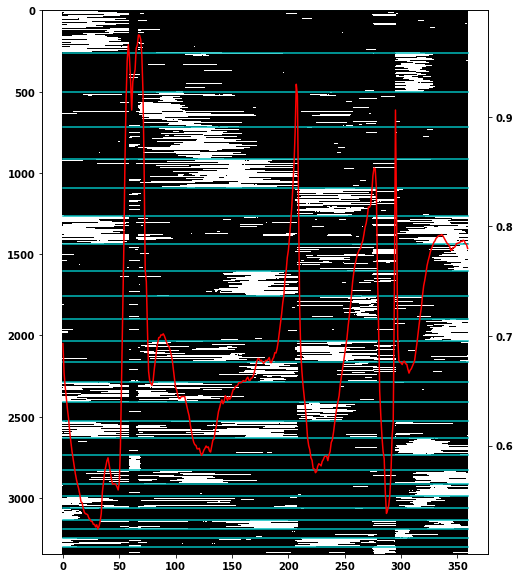

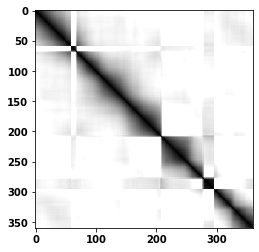

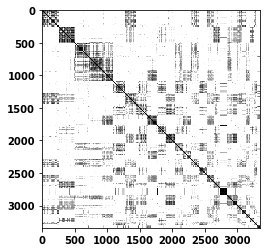

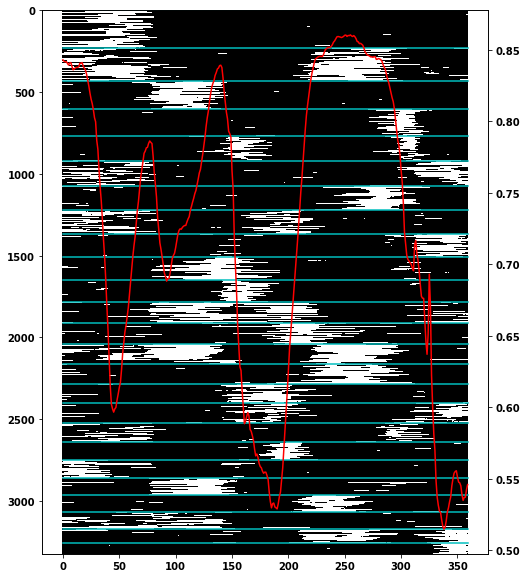

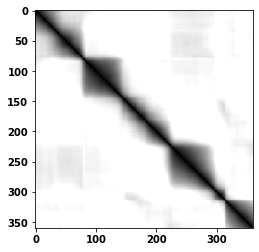

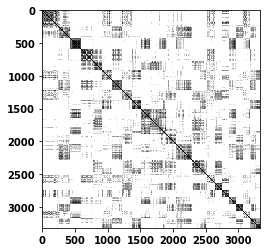

In [320]:
def raster_plot(inp, start, stop):
    r1 = inp['sorted raster']
    csz_lst = inp['csz_lst']
    fig, ax = plt.subplots(figsize=(8,10))
    ax.imshow(r1.T, cmap='gray', aspect='auto')
    count = 0
    T = stop - start
    for sz in csz_lst:
        ax.plot(range(T), np.ones(T) * count, color='c')
        count += sz
    ax1 = ax.twinx()
    ax1.plot(dynamic_ev_deg_correlation[start:stop], color='r', linewidth=1.5)
    plt.show()

    ###
    fig, ax = plt.subplots()
    tm = np.corrcoef(r1)
    tm = np.clip(tm, 0., 1.)
    ax.imshow(tm, cmap='gray_r')
#     ax1 = ax.twinx()
#     ax1.plot(dynamic_ev_deg_correlation[start:stop], color='r', linewidth=1.5)
#     plt.show()
    
    fig, ax = plt.subplots()
    tm = np.corrcoef(r1.T)
    tm = np.clip(tm, 0., 1.)
    ax.imshow(tm, cmap='gray_r')
    plt.show()
    
    
%matplotlib inline
raster_plot(baseline_superhub_outputs[0], 0, 360)
raster_plot(presz_superhub_outputs[0], 620, 620+360)#sz_start_idx  - 120)


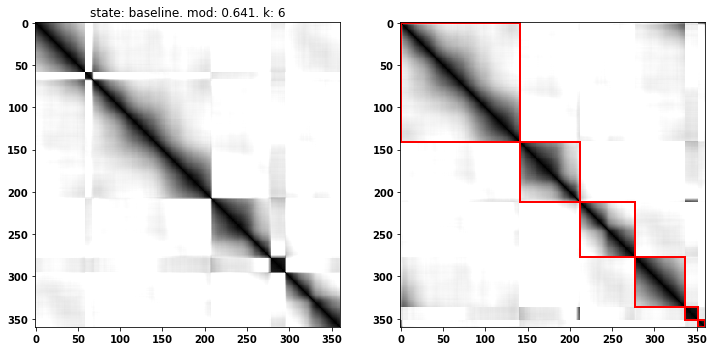

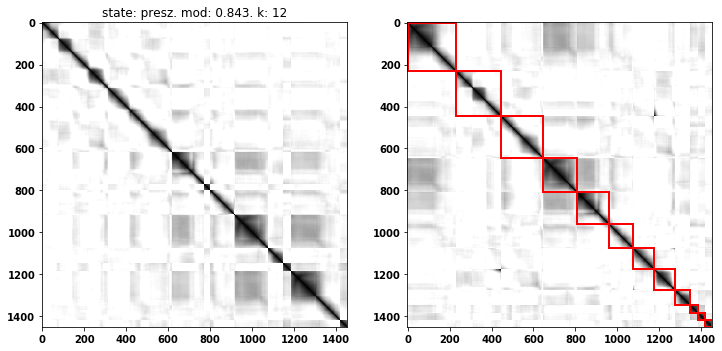

In [165]:
def plot_tcorr_sorted(X, key, state):
    import matplotlib.patches as patches
    sorted_raster = X[key]['sorted raster']
    tlabels, tmod = X[key]['tlabels'], X[key]['tmod']
    raster_tcorr = np.corrcoef(sorted_raster)
    
    time_sorted_raster = np.zeros_like(sorted_raster, dtype='float32')
    count = 0
    patches_lst = []
    for label in list(set(tlabels)):
        tidxs = np.where(np.asarray(tlabels) == label)[0]
        lent = len(tidxs)
        time_sorted_raster[count:count+lent,:] = sorted_raster[tidxs,:]
        patches_lst.append(patches.Rectangle((count,count), lent, lent, linewidth=2, edgecolor='r', facecolor='none'))
        count += lent
    time_sorted_raster_tcorr = np.corrcoef(time_sorted_raster)
    
    fig, ax = plt.subplots(1,2,figsize=(12,8))
    ax[0].imshow(raster_tcorr, cmap='gray_r', vmin=0., vmax=1.)
    ax[0].set_title('state: %s. mod: %0.3f. k: %d' % (state, tmod, len(set(tlabels))))
    ax[1].imshow(time_sorted_raster_tcorr, cmap='gray_r', vmin=0., vmax=1.)
    for p in patches_lst:
        ax[1].add_patch(p)
    plt.show()
    
    
plot_tcorr_sorted(baseline_superhub_outputs, 0, 'baseline')
plot_tcorr_sorted(presz_superhub_outputs, 0, 'presz')

    
#plot_tcorr_sorted(baseline_superhub_outputs, 8, 'baseline')
#plot_tcorr_sorted(presz_superhub_outputs, 8, 'presz')


2086 3323


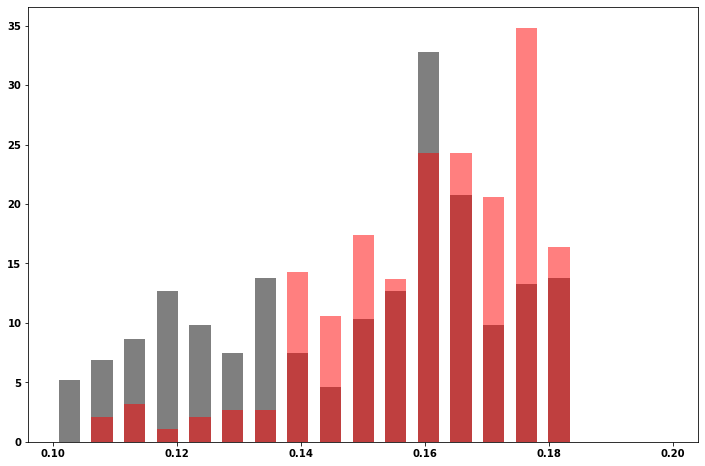

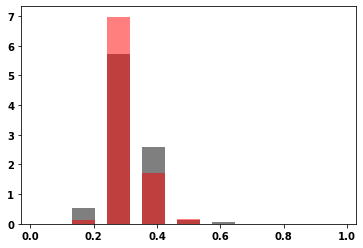

baseline mean: 0.297
presz mean: 0.299


In [321]:
%matplotlib inline
key = 0
overlapping_idxs = set(baseline_superhub_outputs[key]['valid idxs']) & set(presz_superhub_outputs[key]['valid idxs'])
print(len(overlapping_idxs), len(presz_superhub_outputs[key]['valid idxs']))

# superhub_mean_cc = mean_cc(dynamic_clustering_coefficient, dynamic_degree_centrality_percentile, 
#                           dynamic_eigenvector_centrality_percentile, 'superhubs')
# full_mean_cc = mean_cc(dynamic_clustering_coefficient, dynamic_degree_centrality_percentile, 
#                           dynamic_eigenvector_centrality_percentile, None)

# fig, ax = plt.subplots(figsize=(14,6))
# ax.plot(complete_times, np.mean(traces,axis=0), color='k')
# ax2 = ax.twinx()
# ax2.plot(dynamic_times, superhub_mean_cc, color='r')
# ax2.plot(dynamic_times, full_mean_cc, color='b')
# plt.show()

baseline_factive = raster_frac_active(baseline_superhub_outputs[key]['sorted raster'])
presz_factive    = raster_frac_active(presz_superhub_outputs[key]['sorted raster'])

bins = np.linspace(0.100, 0.20, 20)
plt.figure(figsize=(12,8))
plt.hist(baseline_factive, color='k', bins=bins, density=True, rwidth=0.65, alpha=0.5)
plt.hist(presz_factive, color='r',bins=bins, density=True, rwidth=0.65, alpha=0.5)

baseline_assembly_sparsity = raster_assembly_sparsity(baseline_superhub_outputs[key]['raster'], 
                                                      baseline_superhub_outputs[key]['labels'], cutoff=0.1)
presz_assembly_sparsity = raster_assembly_sparsity(presz_superhub_outputs[key]['raster'], 
                                                   presz_superhub_outputs[key]['labels'], cutoff=0.10)

bins = np.linspace(0., 1., 10)
# plt.figure(figsize=(8,8))
# plt.plot(np.linspace(0., 1., len(presz_assembly_sparsity)), presz_assembly_sparsity, color='r')
# plt.plot(np.linspace(0., 1., len(baseline_assembly_sparsity)), baseline_assembly_sparsity, color='k')
# plt.show()

plt.figure()
plt.hist(baseline_assembly_sparsity, color='k', bins=bins, density=True, rwidth=0.65, alpha=0.5)
plt.hist(presz_assembly_sparsity, color='r', bins=bins, density=True, rwidth=0.65, alpha=0.5)
plt.show()

print('baseline mean: %0.3f' % np.mean(baseline_assembly_sparsity))
print('presz mean: %0.3f' % np.mean(presz_assembly_sparsity))

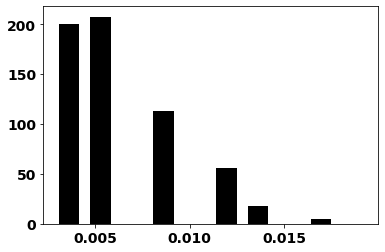

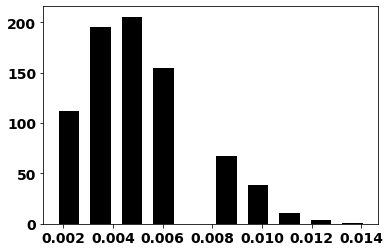

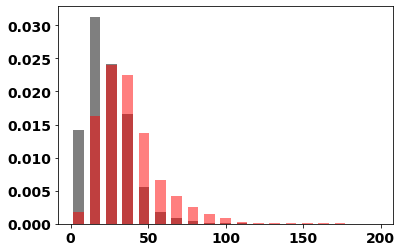

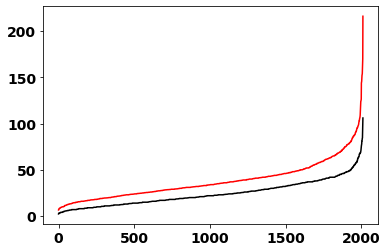

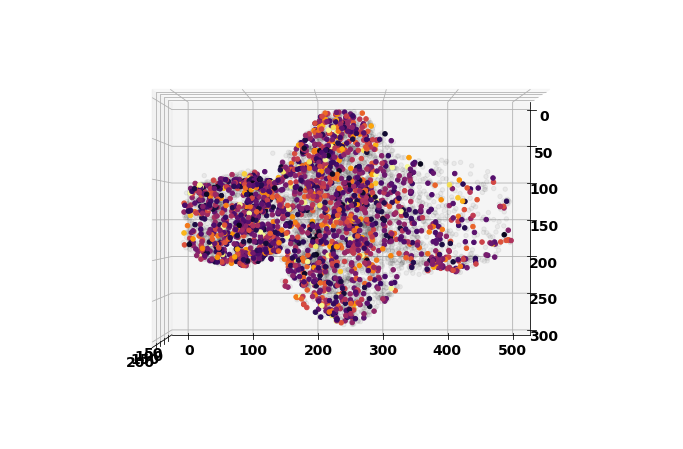

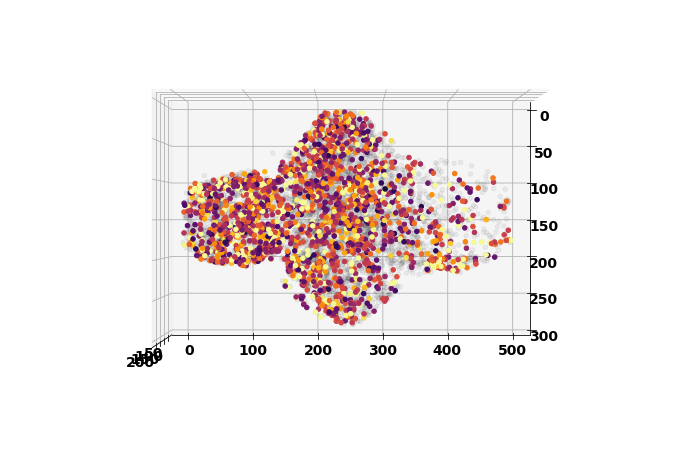

In [40]:
key = 0
X1 = baseline_superhub_outputs
X2 = presz_superhub_outputs
T1, N1 = X1[key]['raster'].shape
T2, N2 = X2[key]['raster'].shape

rasterX1, rasterX2, overlap_idxs = get_overlapped(X1[key]['raster'], X1[key]['valid idxs'], X2[key]['raster'], X2[key]['valid idxs'])
overlap_X1_locs = [list(X1[key]['valid idxs']).index(i) for i in overlap_idxs]
overlap_X2_locs = [list(X2[key]['valid idxs']).index(i) for i in overlap_idxs]

valid_coords_X1 = coords[X1[key]['valid idxs'][overlap_X1_locs]]
valid_coords_X2 = coords[X2[key]['valid idxs'][overlap_X2_locs]]


X1_continuous_active = continuously_active(rasterX1)
X2_continuous_active = continuously_active(rasterX2)


X1_normalized_continuous_active = X1_continuous_active / float(T1)
X2_normalized_continuous_active = X2_continuous_active / float(T2)

bins = np.linspace(0., 200, 20)
plt.hist(X1_continuous_active, color='k', rwidth=0.65, density=True, bins=bins, alpha=0.5)
plt.hist(X2_continuous_active, color='r', rwidth=0.65, density=True, bins=bins, alpha=0.5)
plt.show()

plt.figure()
plt.plot(np.sort(X1_continuous_active), color='k')
plt.plot(np.sort(X2_continuous_active), color='r')
plt.show()

# plt.figure()
# plt.boxplot([X1_continuous_active, X2_continuous_active], positions=[1,2])
# plt.show()
# print(np.mean(X1_continuous_active), np.mean(X2_continuous_active))
# t, p = kruskal(X1_normalized_continuous_active, X2_normalized_continuous_active)
# print(t,p)

plot_time_superhub_active(X1_continuous_active, T1, valid_coords_X1, coords)
plot_time_superhub_active(X2_continuous_active, T2, valid_coords_X2, coords)


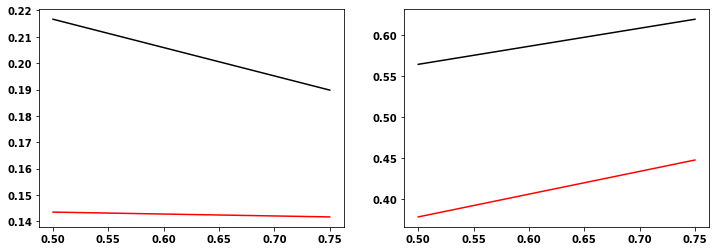

In [91]:
plot_modularities([baseline_superhub_outputs, presz_superhub_outputs], temporal_cutoffs, ['baseline shub', 'presz shub'])
#plot_modularities([baseline_hub_outputs, presz_hub_outputs], temporal_cutoffs, ['baseline hub', 'presz hub'])
#plot_modularities([baseline_naivehub_outputs, presz_naivehub_outputs], temporal_cutoffs, ['baseline nhub', 'presz nhub'])


#plot_modularities([baseline_naivehub_outputs, baseline_superhub_outputs], temporal_cutoffs, ['baseline hub', 'baseline superhub'])
#plot_modularities([presz_naivehub_outputs, presz_superhub_outputs], temporal_cutoffs, ['presz hub', 'presz superhub'])


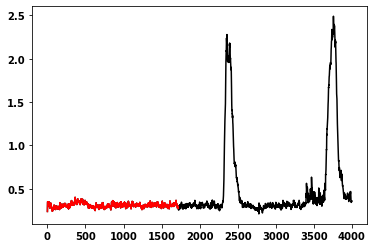

In [30]:
plt.figure()
#1900, 2900
plt.plot(np.mean(traces,axis=0)[0:4000], color='k')
plt.plot(np.arange(0, 1720),np.mean(traces,axis=0)[0:1720], color='r')


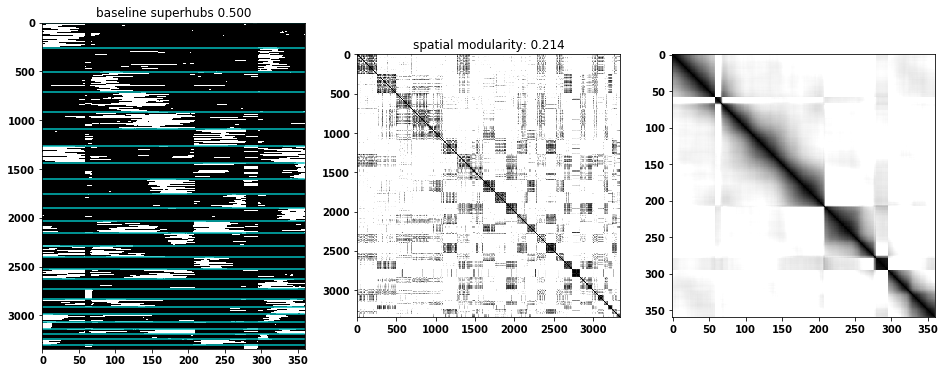

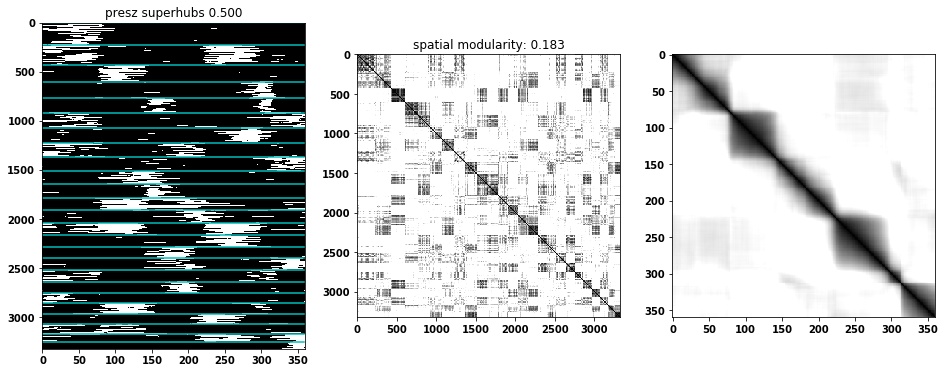

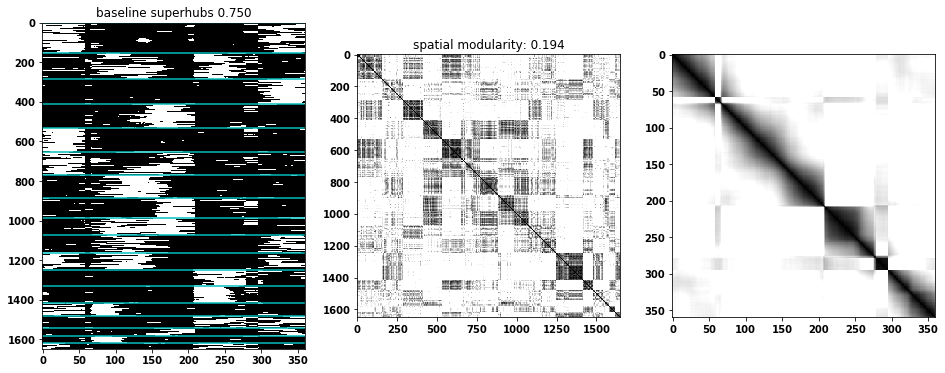

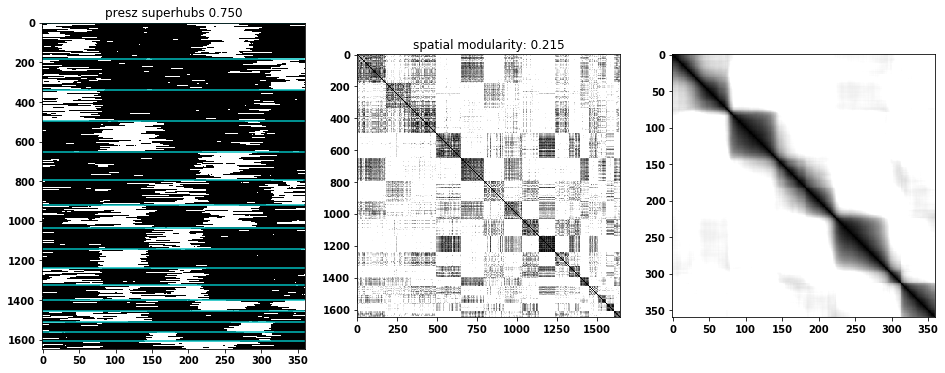

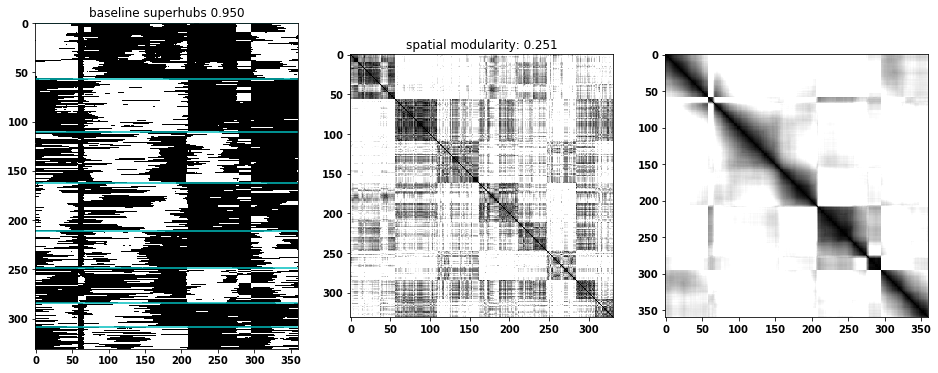

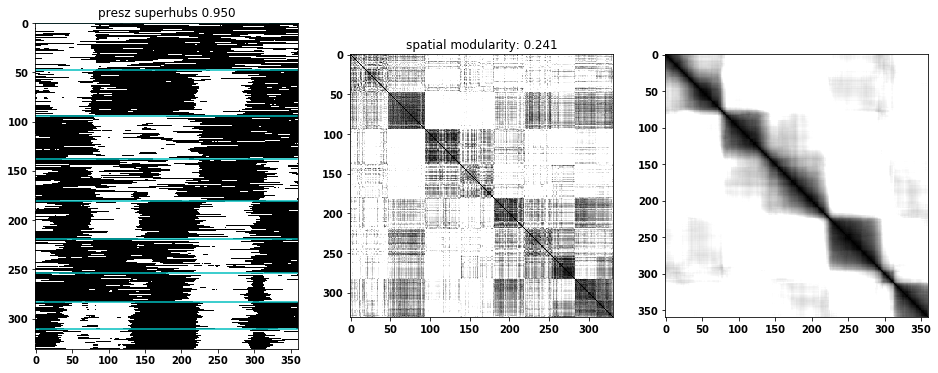

In [322]:
#mean_trace = np.mean(traces,axis=0)
sorted_keys = np.sort(list(baseline_superhub_outputs.keys()))
for key in sorted_keys:
    plot_raster_info(None, range(0, 360), baseline_superhub_outputs[key], 'baseline superhubs %0.3f' % temporal_cutoffs[key])
    plot_raster_info(None, range(0, 360), presz_superhub_outputs[key], 'presz superhubs %0.3f' % temporal_cutoffs[key])



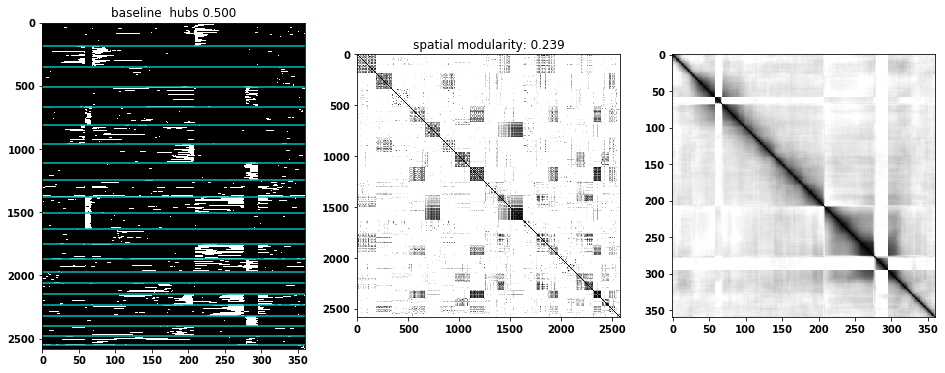

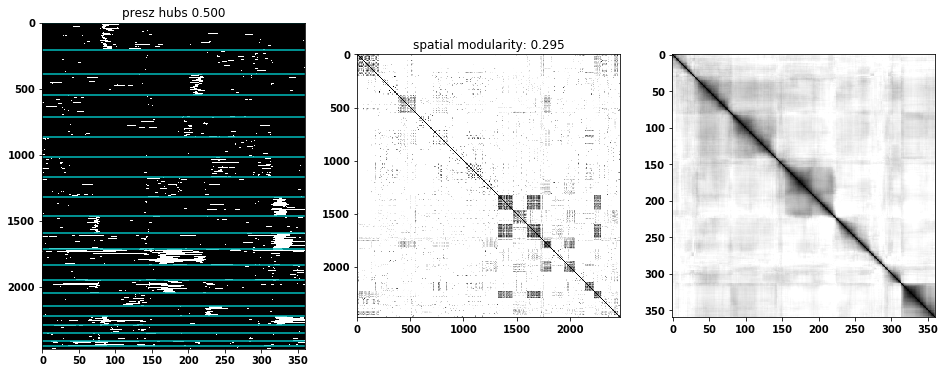

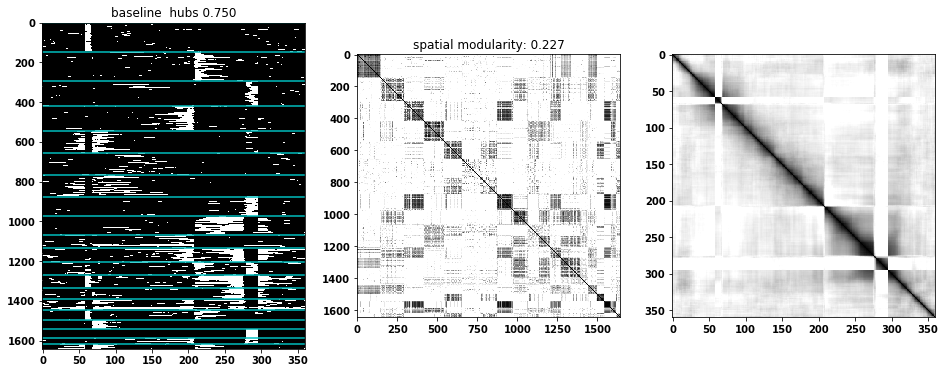

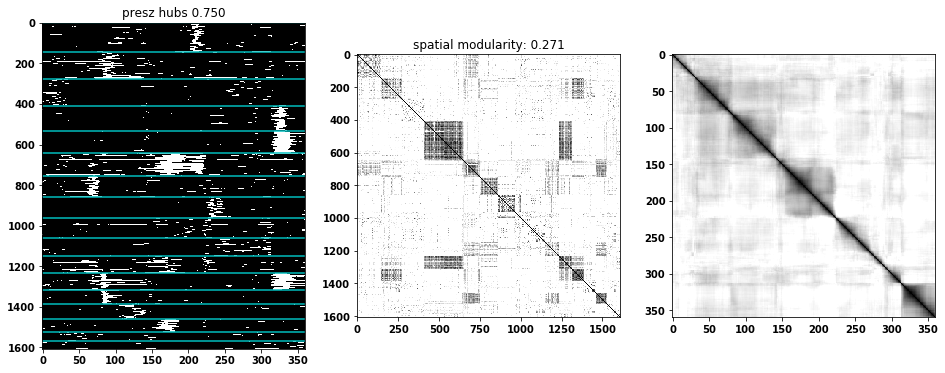

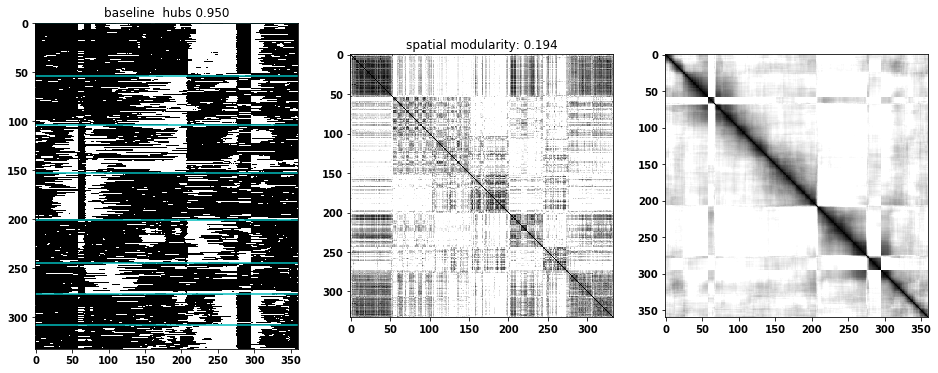

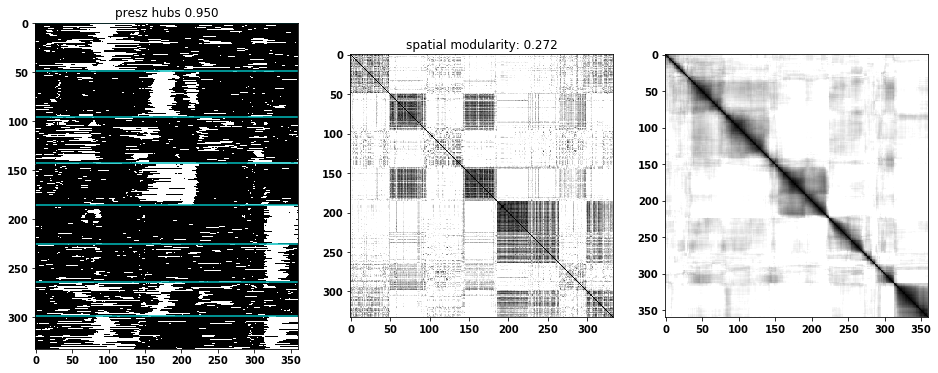

In [252]:
mean_trace = np.mean(traces,axis=0)
sorted_keys = np.sort(list(baseline_hub_outputs.keys()))
for key in sorted_keys:
    plot_raster_info(None, range(0, 360), baseline_hub_outputs[key], 'baseline  hubs %0.3f' % temporal_cutoffs[key])
    plot_raster_info(None, range(0, 360), presz_hub_outputs[key], 'presz hubs %0.3f' % temporal_cutoffs[key])



25
21


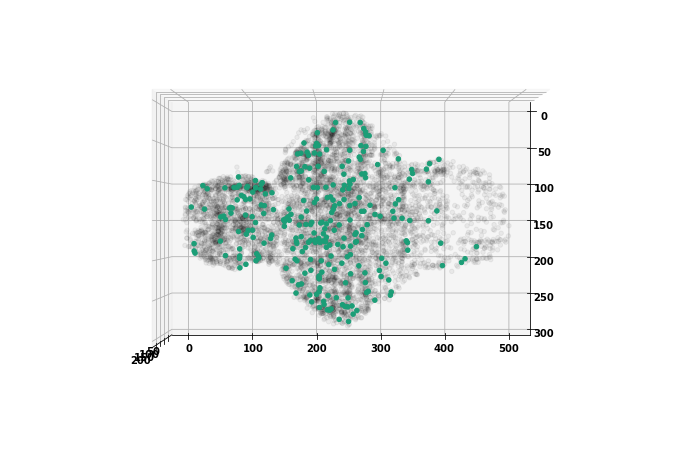

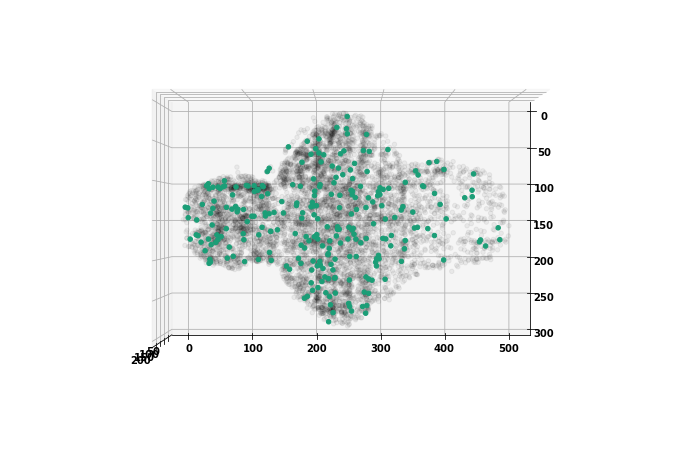

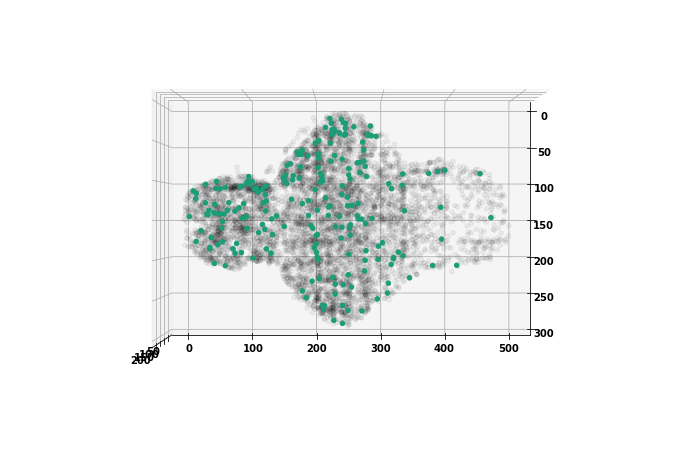

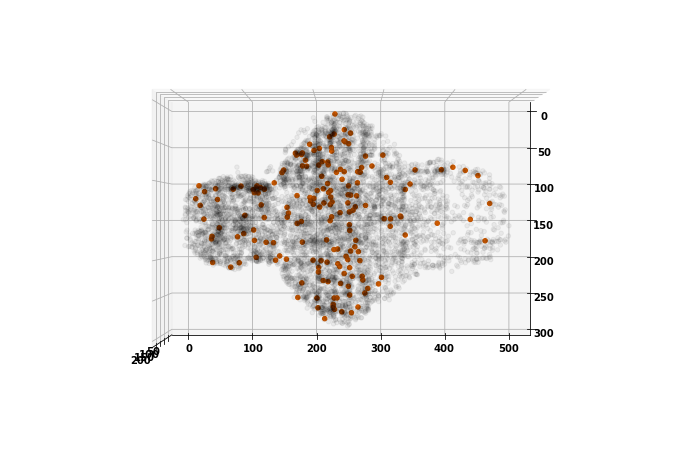

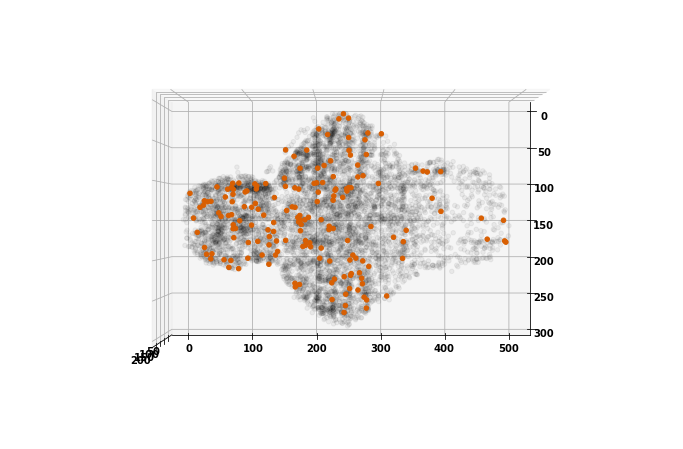

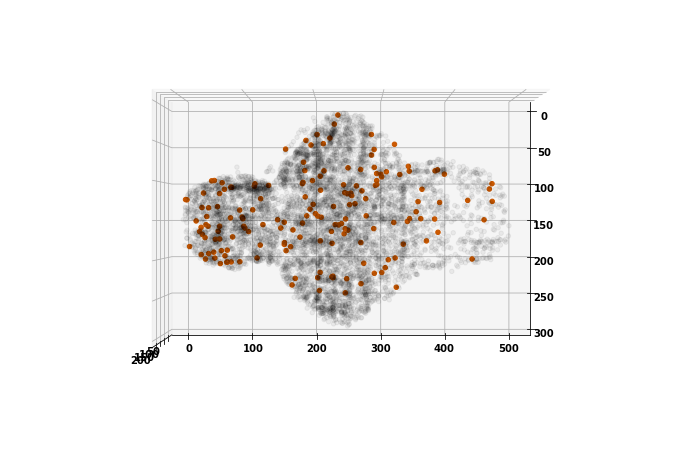

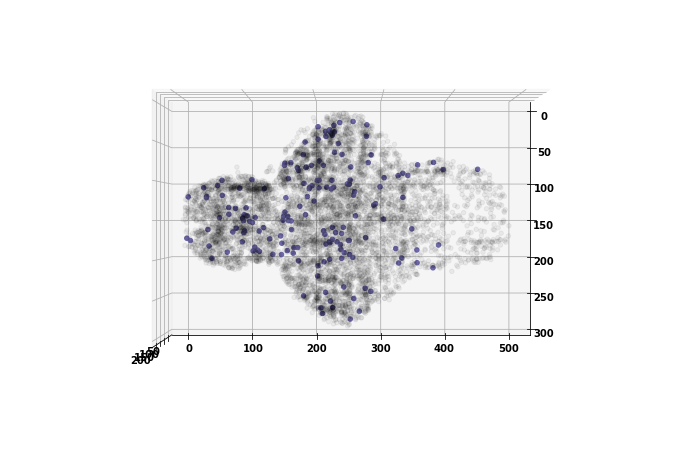

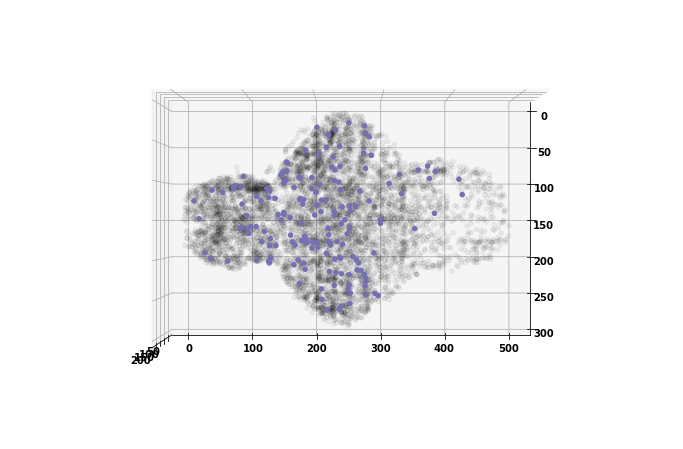

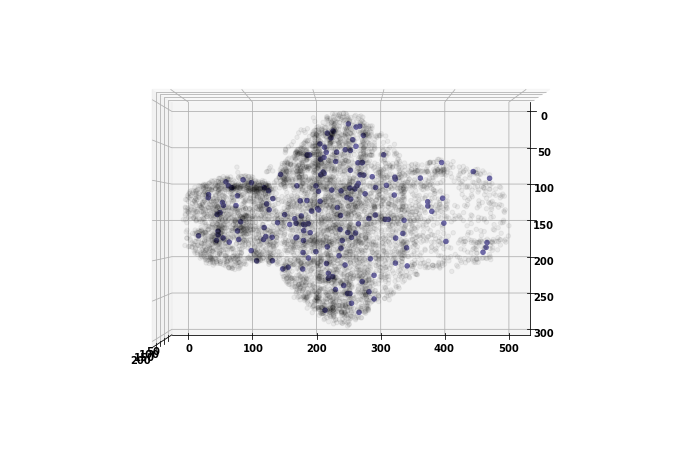

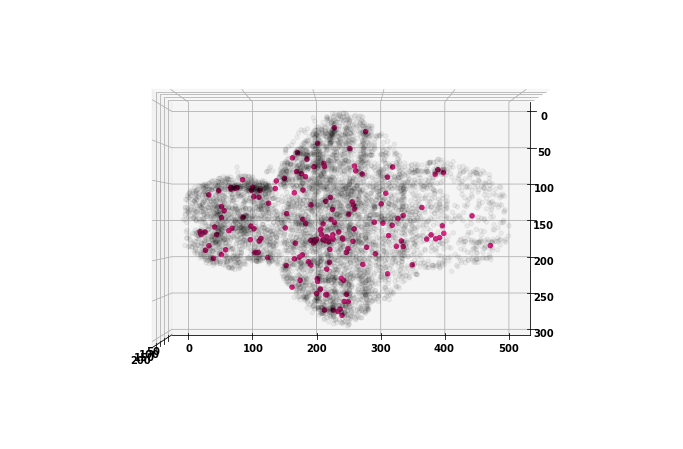

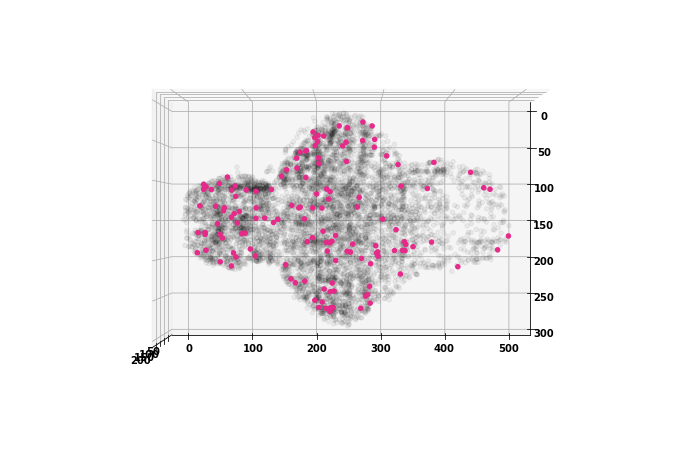

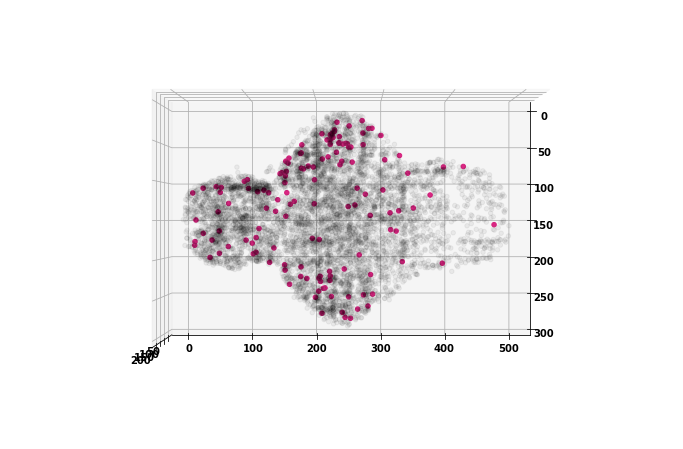

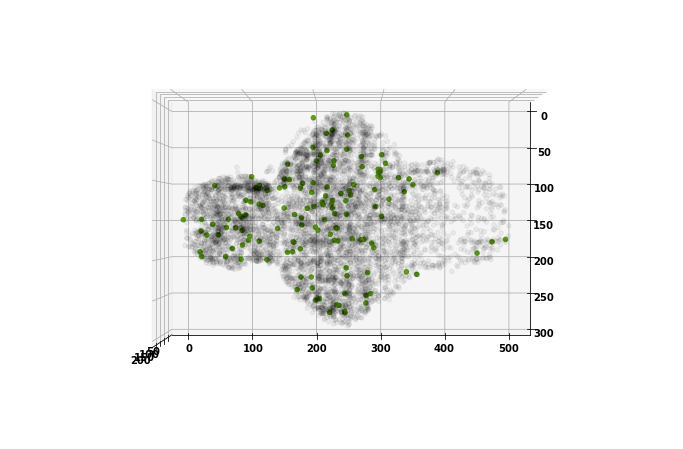

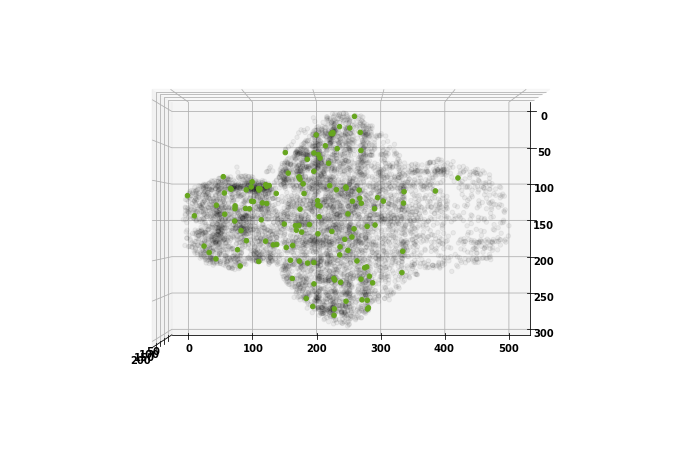

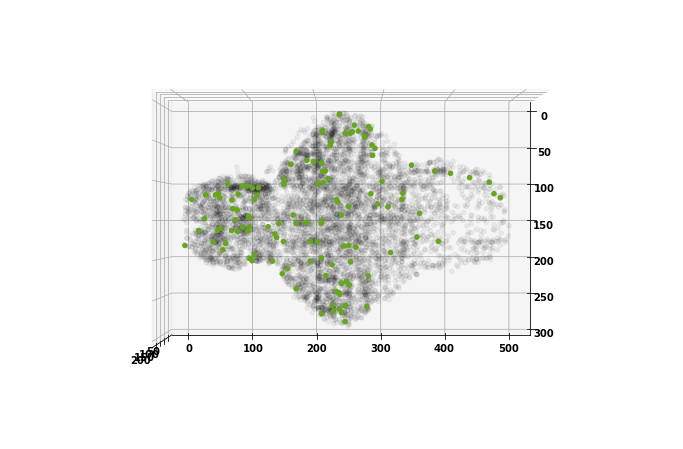

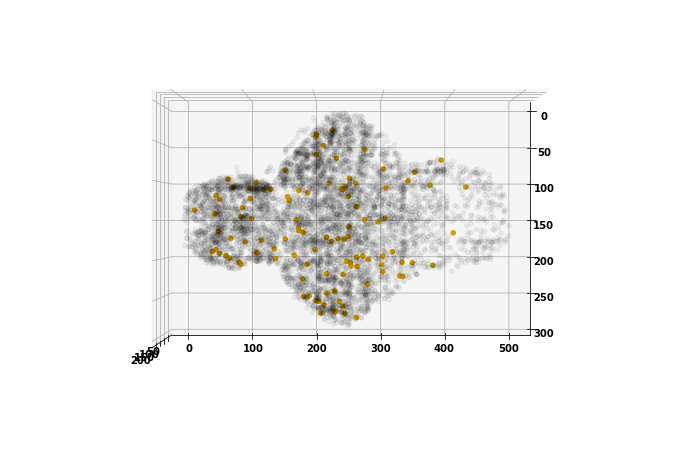

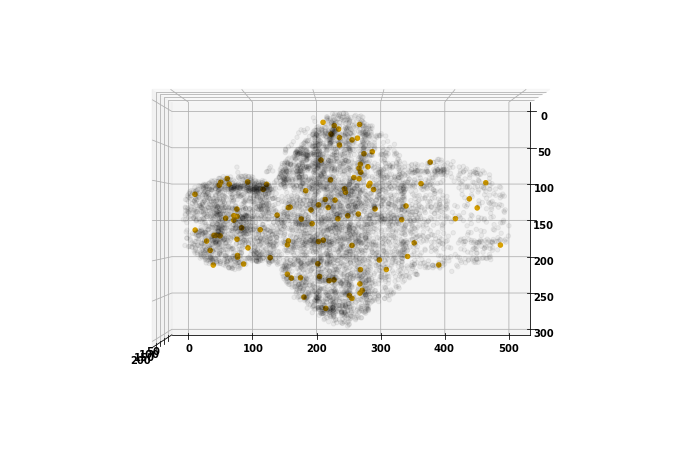

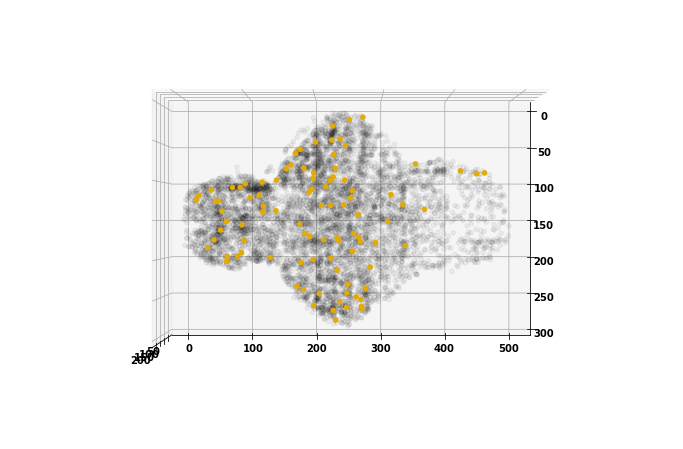

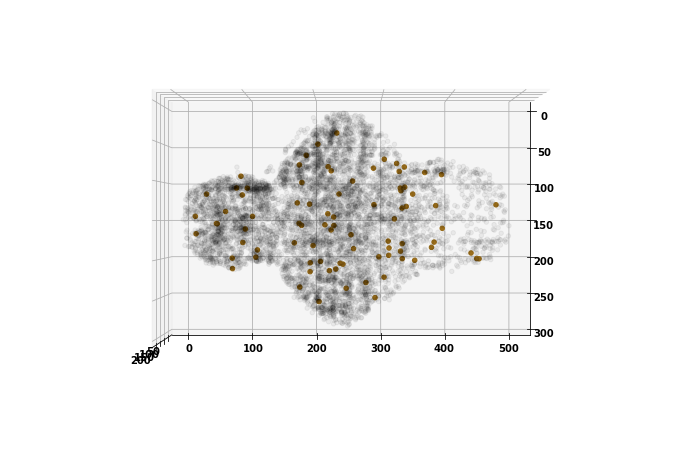

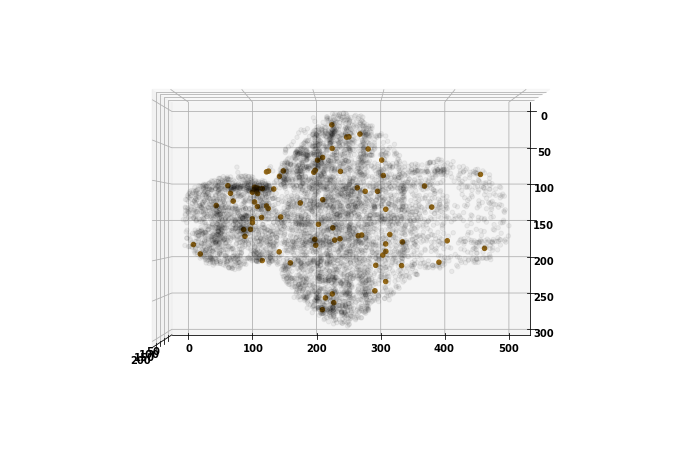

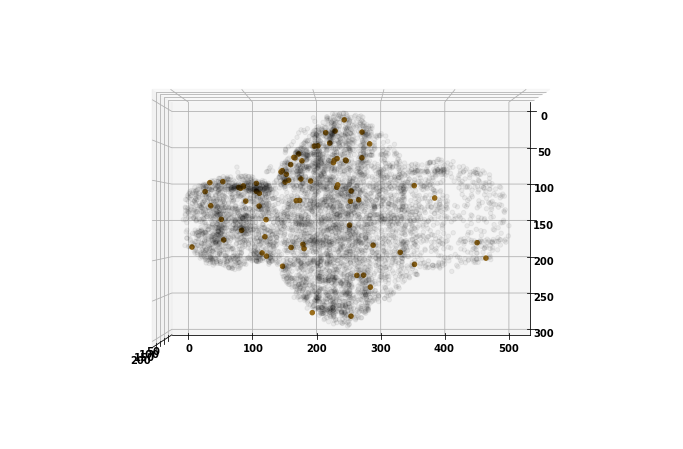

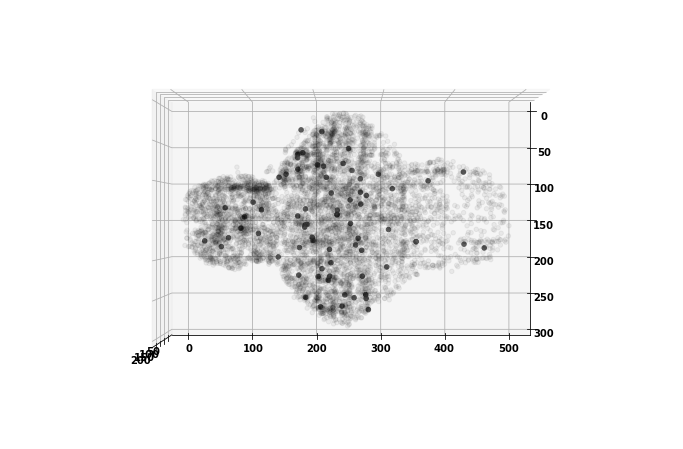

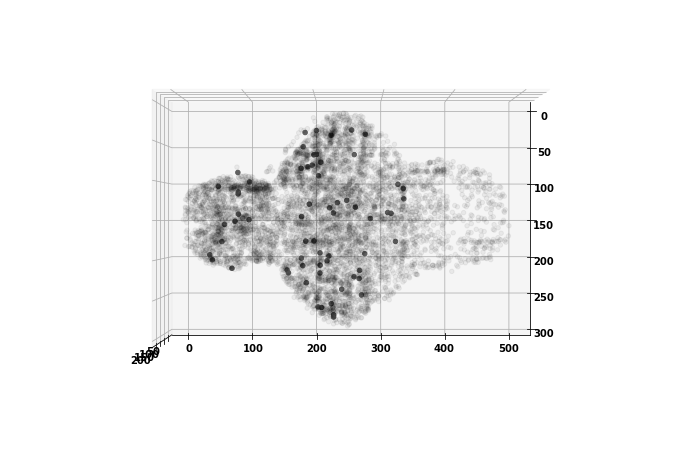

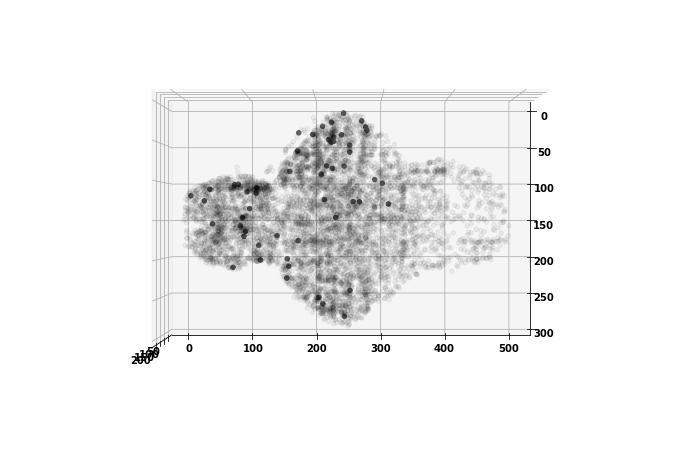

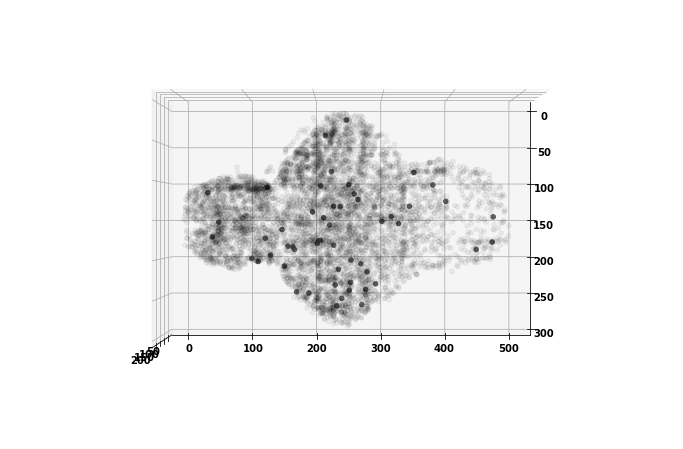

In [161]:
def plot_superhub_subnetworks(spatial_coords, valid_idxs, raster, cluster_ids, view):

    cluster_ids = np.asarray(cluster_ids, dtype='uint32')
    cluster_id_set = np.sort(list(set(cluster_ids)))
    valid_spatial_coords = spatial_coords#[valid_idxs,:]
    
    colors = cm.Dark2(np.linspace(0,1,len(cluster_id_set)))
    #fig = plt.figure(figsize=(12,8))
    #ax = plt.axes(projection='3d')
    #ax.scatter(*coords.T, color='k', alpha=0.05)
    
#     sactive_szs = []
#     for cid in cluster_id_set:
#         ts = np.where(cluster_ids == cid)[0]
#         reduced_raster = raster[ts, :]
#         tactive, sactive = np.where(reduced_raster == 1)
#         sactive = list(set(sactive))
#         sactive_szs.append(len(sactive))
    
#     for cid in np.argsort(sactive_szs)[::-1]:
#         fig = plt.figure(figsize=(12,8))
#         ax = plt.axes(projection='3d')
#         ax.scatter(*coords.T, color='k', alpha=0.05)

#         ts = np.where(cluster_ids == cid)[0]
#         reduced_raster = raster[ts, :]
#         tactive, sactive = np.where(reduced_raster == 1)
#         sactive = list(set(sactive))
#         #ax.scatter(*valid_spatial_coords[sactive,:].T, color=colors[cid], alpha=0.65, s=int(len(ts)/5))
#         ax.scatter(*valid_spatial_coords[sactive,:].T, color=colors[cid], alpha=1.0)
#         ax.view_init(view[0], view[1])
#         plt.show()


    for cid in cluster_id_set:
        fig = plt.figure(figsize=(12,8))
        ax = plt.axes(projection='3d')
        ax.scatter(*coords.T, color='k', alpha=0.05)

#         ts = np.where(cluster_ids == cid)[0]
#         reduced_raster = raster[ts, :]
#         tactive, sactive = np.where(reduced_raster == 1)
#         sactive = list(set(sactive))

        nids = np.where(cluster_ids == cid)[0]
        #ax.scatter(*valid_spatial_coords[sactive,:].T, color=colors[cid], alpha=0.65, s=int(len(ts)/5))
        ax.scatter(*valid_spatial_coords[nids,:].T, color=colors[cid], alpha=1.0)
        ax.view_init(view[0], view[1])
        plt.show()
    


key = 0
X1 = baseline_superhub_outputs
X2 = presz_superhub_outputs
print(len(set(X1[key]['labels'])))
print(len(set(X2[key]['labels'])))
%matplotlib inline

plot_superhub_subnetworks(X1[key]['sorted coords'], X1[key]['valid idxs'], X1[key]['sorted raster'], X1[key]['labels'], [90,0])
#plot_superhub_subnetworks(X1[key]['sorted coords'], X1[key]['valid idxs'], X1[key]['sorted raster'], X1[key]['tlabels'], [45,0])
#plot_superhub_subnetworks(X1[key]['sorted coords'], X1[key]['valid idxs'], X1[key]['sorted raster'], X1[key]['tlabels'], [45,180])

#plot_superhub_subnetworks(X2[key]['sorted coords'], X2[key]['valid idxs'], X2[key]['sorted raster'], X2[key]['labels'], [90,0])
# plot_superhub_subnetworks(X2[key]['sorted coords'], X2[key]['valid idxs'], X2[key]['sorted raster'], X2[key]['tlabels'], [45,0])
# plot_superhub_subnetworks(X2[key]['sorted coords'], X2[key]['valid idxs'], X2[key]['sorted raster'], X2[key]['tlabels'], [45,180])
